In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import pandas as pd

In [3]:
df=pd.read_csv("/home/yadagiri/Downloads/HC3 DATASET FILES/TRAIN AND TEST/HC3train_dataset1.csv")

In [4]:
df

,text,avg line length,vocab,word density,stopwords_count,word count,active,passive,punctuation_count,linking_words_count,...,PART,SCONJ,NUM,X,INTJ,ADP,SYM,SPACE,CCONJ,label
0,['What do you do if the random jury pool inclu...,22.000000,218,45.041322,249,484,22,0,77,92,...,3,44,1,0,1,44,0,0,21,0
1,['Testing a lethal injection involves evaluati...,30.500000,71,58.196721,57,122,1,3,12,33,...,1,13,0,0,0,13,0,0,5,1
2,"[""A dividend is a distribution of a portion of...",34.142857,160,33.472803,253,478,9,5,53,121,...,2,70,4,0,0,70,0,0,11,1
3,"[""I'm sorry for your loss. Dealing with the cr...",36.000000,164,45.555556,188,360,9,1,40,80,...,2,36,0,0,0,36,0,0,9,1
4,['If the default happens through mass monetary...,23.750000,72,75.789474,53,95,3,1,21,12,...,0,12,0,0,0,12,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38911,['Birth control pills are a very effective for...,28.000000,89,63.571429,72,140,4,1,19,18,...,0,14,1,0,0,14,0,0,6,1
38912,['Daylight Saving Time (DST) is a system that ...,45.600000,112,49.122807,120,228,3,2,34,47,...,0,34,3,0,0,34,0,0,4,1
38913,"[""Can they reject a hundred dollar bill as a p...",17.000000,115,67.647059,80,170,8,2,32,27,...,0,17,2,0,1,17,0,0,4,0
38914,['Prom is a formal dance that is held by many ...,31.000000,73,58.870968,62,124,1,3,13,33,...,1,17,0,0,0,17,0,0,7,1


In [5]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn as nn

# Load CSV file
df = pd.read_csv("/home/yadagiri/Downloads/HC3 DATASET FILES/TRAIN AND TEST/HC3train_dataset1.csv")

# Define columns
text_column = "text"
numerical_columns = ['avg line length', 'vocab', 'word density', 'stopwords_count', 'word count', 'active', 'passive', 'punctuation_count', 'linking_words_count', 'NOUN', 'VERB', 'PUNCT', 'DET', 'PRON', 'PROPN', 'ADJ', 'AUX', 'ADV', 'PART', 'SCONJ', 'NUM', 'X', 'INTJ', 'ADP', 'SYM', 'SPACE', 'CCONJ']
y_label_column = "label"

# Split dataset into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, text_column, numerical_columns, label_column, max_length=128):
        # Initialize data
        self.texts = df[text_column].tolist()  # List of strings
        self.numerical_data = df[numerical_columns].values  # Numpy array of numerical data
        self.labels = df[label_column].values  # Numpy array of labels

        # Convert to PyTorch tensors
        self.numerical_data = torch.tensor(self.numerical_data, dtype=torch.float)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

        # Initialize tokenizer and other settings
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Get the text and numerical data for the given index
        text = self.texts[idx]
        numerical = self.numerical_data[idx]

        # Tokenize text and convert it to PyTorch tensors
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Convert input_ids and attention_mask to LongTensor
        input_ids = encoding['input_ids'].squeeze(0).long()
        attention_mask = encoding['attention_mask'].squeeze(0).long()

        # Combine numerical data with input_ids and attention mask
        combined_input = torch.cat((numerical, input_ids, attention_mask), dim=0)

        # Return input_ids, attention_mask, and label separately
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': self.labels[idx]
        }

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Create datasets
train_dataset = CustomDataset(train_df, tokenizer, text_column, numerical_columns, y_label_column)
val_dataset = CustomDataset(val_df, tokenizer, text_column, numerical_columns, y_label_column)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Move model to appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Training and validation loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1_scores = []
val_f1_scores = []
epochs = 3
for epoch in range(epochs):
    # Training loop
    model.train()
    epoch_train_loss = 0
    correct_train_preds = 0
    total_train_preds = 0
    train_predicted_labels = []
    train_true_labels = []
    for batch in train_loader:
        # Move inputs and labels to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        # Forward pass with appropriate input names
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()

        # Track loss
        epoch_train_loss += loss.item()

        # Calculate correct predictions
        _, predicted = torch.max(outputs.logits, 1)
        correct_train_preds += (predicted == labels).sum().item()
        total_train_preds += labels.size(0)

        # Collect predicted and true labels for metrics calculation
        train_predicted_labels.extend(predicted.cpu().numpy())
        train_true_labels.extend(labels.cpu().numpy())

    # Calculate training loss and metrics
    train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds
    train_precision = precision_score(train_true_labels, train_predicted_labels, average='weighted')
    train_recall = recall_score(train_true_labels, train_predicted_labels, average='weighted')
    train_f1 = f1_score(train_true_labels, train_predicted_labels, average='weighted')

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")

    # Validation loop
    model.eval()
    epoch_val_loss = 0
    correct_val_preds = 0
    total_val_preds = 0
    val_predicted_labels = []
    val_true_labels = []

    with torch.no_grad():
        for batch in val_loader:
            # Move inputs and labels to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass with appropriate input names
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Track validation loss
            epoch_val_loss += loss.item()

            # Calculate correct predictions
            _, predicted = torch.max(outputs.logits, 1)
            correct_val_preds += (predicted == labels).sum().item()
            total_val_preds += labels.size(0)

            # Collect predicted and true labels for metrics calculation
            val_predicted_labels.extend(predicted.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    # Calculate validation loss and metrics
    val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / total_val_preds
    val_precision = precision_score(val_true_labels, val_predicted_labels, average='weighted')
    val_recall = recall_score(val_true_labels, val_predicted_labels, average='weighted')
    val_f1 = f1_score(val_true_labels, val_predicted_labels, average='weighted')

    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")

# This concludes the training and validation loop.


2024-06-23 15:24:53.998728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 15:24:53.998904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 15:24:54.247199: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-23 15:24:54.922482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 15:25:02.288458: W tensorflow/comp

Epoch 1/3, Train Loss: 0.0529, Train Accuracy: 0.9832, Train Precision: 0.9832, Train Recall: 0.9832, Train F1: 0.9832
Val Loss: 0.0340, Val Accuracy: 0.9873, Val Precision: 0.9876, Val Recall: 0.9873, Val F1: 0.9873
Epoch 2/3, Train Loss: 0.0087, Train Accuracy: 0.9972, Train Precision: 0.9972, Train Recall: 0.9972, Train F1: 0.9972
Val Loss: 0.0182, Val Accuracy: 0.9952, Val Precision: 0.9953, Val Recall: 0.9952, Val F1: 0.9952
Epoch 3/3, Train Loss: 0.0061, Train Accuracy: 0.9977, Train Precision: 0.9977, Train Recall: 0.9977, Train F1: 0.9977
Val Loss: 0.2380, Val Accuracy: 0.9498, Val Precision: 0.9543, Val Recall: 0.9498, Val F1: 0.9496


In [6]:
import torch

# Assuming model is your BERT model instance
model_state_dict = model.state_dict()
torch.save(model_state_dict, 'BERT_MODELHC3TRAINDATA.pth')


In [7]:
from transformers import BertConfig, BertForSequenceClassification

# Load the configuration
config = BertConfig.from_pretrained('bert-base-uncased')

# Create an instance of the model architecture
model = BertForSequenceClassification(config)

# Load the saved model state dictionary
model_state_dict = torch.load('BERT_MODELHC3TRAINDATA.pth')

# Load the model state dictionary
model.load_state_dict(model_state_dict)


<All keys matched successfully>

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
# Load test dataset
df = pd.read_csv("/home/yadagiri/Downloads/HC3 DATASET FILES/TRAIN AND TEST/HC3test_dataset1.csv")

# Define columns
text_column = "text"
numerical_columns = ['avg line length', 'vocab', 'word density', 'stopwords_count', 'word count', 'active', 'passive', 'punctuation_count', 'linking_words_count', 'NOUN', 'VERB', 'PUNCT', 'DET', 'PRON', 'PROPN', 'ADJ', 'AUX', 'ADV', 'PART', 'SCONJ', 'NUM', 'X', 'INTJ', 'ADP', 'SYM', 'SPACE', 'CCONJ']
y_label_column = "label"

# Create DataLoader for test set
batch_size = 32
test_dataset = CustomDataset(df, tokenizer, text_column, numerical_columns, y_label_column)
#test_dataset = CustomDataset(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#test_dataset = CustomDataset(test_df['text'], test_df['label'], tokenizer)  # Assuming 'binary_label' is the name of the label column
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Initialize empty lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Evaluate model on test set
model.eval()
test_loss = 0
correct_preds = 0
total_preds = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_preds / total_preds

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print metrics
print(f"Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


Test Loss: 0.2759493105580221, Test Accuracy: 0.9409950657894737
Precision: 0.8945916114790287, Recall: 0.9997944078947368, F1 Score: 0.9442718446601941
Confusion Matrix:
[[4291  573]
 [   1 4863]]


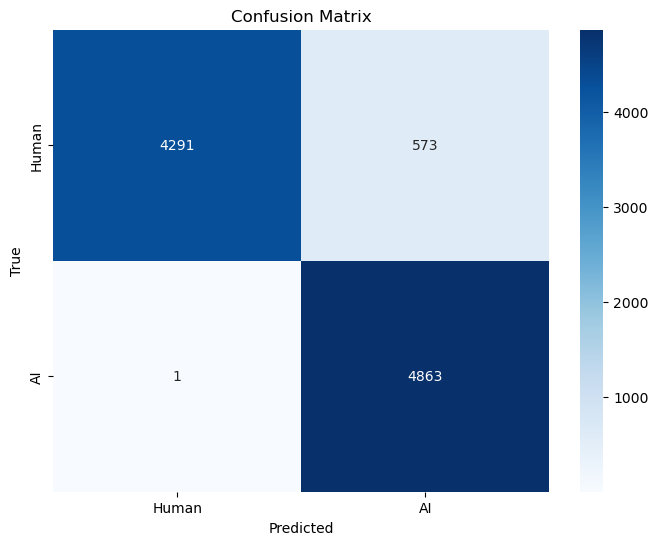

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

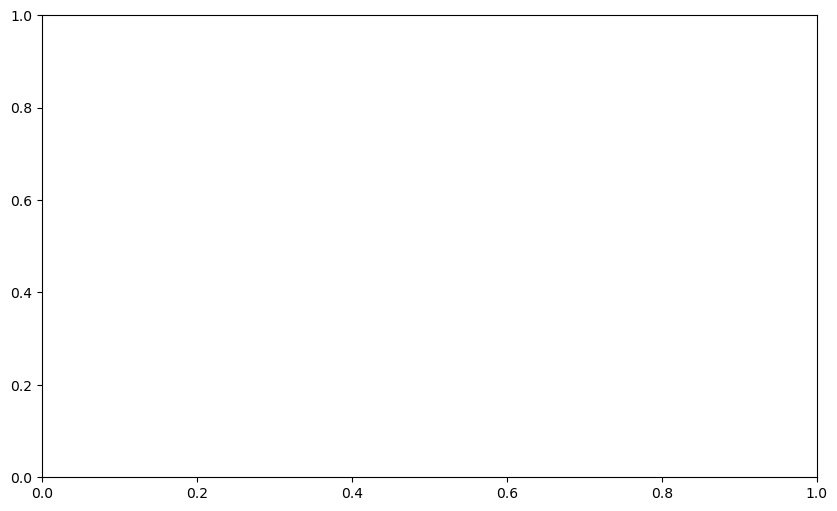

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix for test set
y_true = df['label']
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        y_pred.extend(predicted.cpu().numpy())
class_names = ['Human', 'AI']  # Rename '0' to 'Human' and '1' to 'AI'
plot_confusion_matrix(y_true, y_pred, labels=class_names)
# plot_confusion_matrix(y_true, y_pred, labels=['0', '1'])  # Replace labels with actual class labels if different

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
